# Feature Engineering

### Initializations

In [1]:
import ast
import os
import pickle
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler

from evaluation.experiment import Experiment
from integrations.databricks.auth import setup_mlflow
from models.config import baseline_experiment_configs
from models.setup import experiment_setup
from utils.dataset import Dataset

load_dotenv()

setup_mlflow()
mlflow_path = os.getenv('MLFLOW_FEATURE_ENG')
sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=UserWarning)

SEED = 42

In [2]:
# Data import
DATA_PATH = Path(os.getenv('PROJECT_ROOT'), '.') / 'data'
TRACKS_FILE = DATA_PATH / 'spotify_track_genres_preprocessed.csv'

tracks = pd.read_csv(TRACKS_FILE)
tracks['artist_genres'] = tracks['artist_genres'].apply(ast.literal_eval)
tracks['artist_ids'] = tracks['artist_ids'].apply(ast.literal_eval)

In [3]:
# Inspect data
tracks.info()
tracks.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10416 entries, 0 to 10415
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          10416 non-null  object 
 1   duration_ms       10416 non-null  int64  
 2   track_name        10416 non-null  object 
 3   track_popularity  10416 non-null  int64  
 4   acousticness      10416 non-null  float64
 5   danceability      10416 non-null  float64
 6   energy            10416 non-null  float64
 7   instrumentalness  10416 non-null  float64
 8   key               10416 non-null  int64  
 9   liveness          10416 non-null  float64
 10  loudness          10416 non-null  float64
 11  mode              10416 non-null  int64  
 12  speechiness       10416 non-null  float64
 13  tempo             10416 non-null  float64
 14  time_signature    10416 non-null  int64  
 15  valence           10416 non-null  float64
 16  artist_ids        10416 non-null  object

,duration_ms,track_popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,n_artists,n_genres
count,1.041600e+04,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000
mean,2.286264e+05,52.253744,0.360780,0.577236,0.564434,0.205984,5.245776,0.174369,-9.679182,0.612903,0.086908,117.952822,3.886425,0.473638,1.384121,4.404570
std,1.056449e+05,24.445176,0.353521,0.194247,0.275336,0.349380,3.554538,0.139941,6.641682,0.487109,0.088110,30.271137,0.439159,0.264467,0.787452,3.528924
min,2.560000e+04,0.000000,0.000002,0.000000,0.001100,0.000000,0.000000,0.015700,-47.903000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.736338e+05,40.000000,0.036650,0.452000,0.364000,0.000000,2.000000,0.093100,-11.953000,0.000000,0.036800,94.195500,4.000000,0.249000,1.000000,2.000000
50%,2.135395e+05,56.000000,0.216000,0.596000,0.603000,0.000190,5.000000,0.119000,-7.617500,1.000000,0.049000,118.005000,4.000000,0.472000,1.000000,4.000000
75%,2.584020e+05,71.000000,0.699000,0.726000,0.791000,0.266250,8.000000,0.206000,-5.264750,1.000000,0.091000,137.644500,4.000000,0.688000,2.000000,6.000000
max,2.668693e+06,100.000000,0.996000,0.979000,0.999000,0.994000,11.000000,1.000000,2.015000,1.000000,0.937000,217.969000,5.000000,0.988000,16.000000,91.000000


In [4]:
tracks.head()

,track_id,duration_ms,track_name,track_popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_ids,n_artists,artist_genres,n_genres
0,000u1dTg7y1XCDXi80hbBX,300600,I Don't Want A Lover,1,0.196000,0.756,0.470,0.000487,7,0.1260,-12.615,1,0.0394,120.484,4,0.4300,['5JsdVATHNPE0XdMFMRoSuf'],1,"[new wave pop, new romantic, scottish rock]",3
1,003FTlCpBTM4eSqYSWPv4H,233266,"Swing, Swing",70,0.000065,0.553,0.717,0.128000,7,0.0385,-5.857,1,0.0318,127.947,4,0.3180,['3vAaWhdBR38Q02ohXqaNHT'],1,"[modern rock, post-grunge, neon pop punk, pop ...",7
2,003vvx7Niy0yvhvHt4a68B,222973,Mr. Brightside,90,0.001210,0.352,0.911,0.000000,1,0.0995,-5.230,1,0.0747,148.033,4,0.2360,['0C0XlULifJtAgn6ZNCW2eu'],1,"[alternative rock, rock, permanent wave, moder...",5
3,008RKiNmjW5Lb6Ocumq6MA,298666,TWO OF US,46,0.927000,0.144,0.188,0.684000,4,0.1520,-13.680,0,0.0399,85.762,4,0.0743,['6mOCYCpXBAmulHN4kMfQaa'],1,[anime score],1
4,009ImBOrIUlWgla8U05RAC,228878,Unconditionally,82,0.002730,0.432,0.725,0.000000,7,0.2080,-4.862,1,0.0431,128.902,4,0.3530,['6jJ0s89eD6GaHleKKya26X'],1,[pop],1


In [6]:
# Store data fields names that will be used for developing features/training
RAW_TRAINING_FEATURES = [
    'duration_ms', 
    'acousticness', 
    'danceability', 
    'energy', 
    'instrumentalness', 
    'key', 
    'liveness', 
    'loudness', 
    'mode',
    'speechiness', 
    'tempo', 
    'time_signature', 
    'valence'
]

In [9]:
genre_counts = tracks.copy()[['artist_genres']].explode('artist_genres').value_counts()

### Label encoding

From the previously conducted EDA, it is apparent that the distribution of genres is highly skewed towards rare genres, shown again below. This distribution gives rise to two problems:
- There is a possibility that a rare label can appear in the test set without appearing in the training set
- A rare label can appear in the training set without appearing in the test set, or it can appear too few times for sufficient training

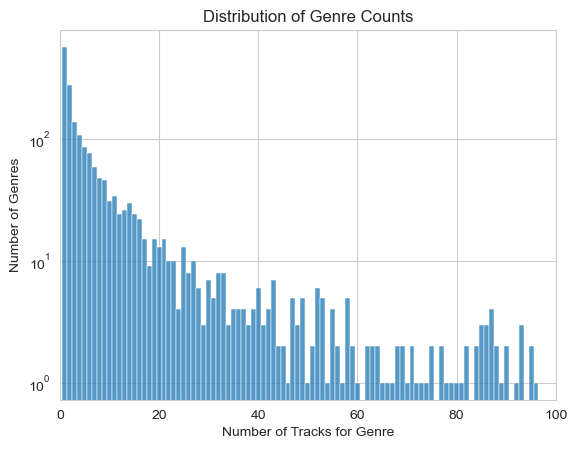

In [10]:
plt.title('Distribution of Genre Counts')
plt.xlabel('Number of Tracks for Genre')
plt.ylabel('Number of Genres')
plt.yscale("log")
plt.xlim([0, 100])
sns.histplot(genre_counts, discrete=True)
plt.show()

For a train-test split of about 80-20, there should be at least five instances of any label such that one of them can appear in the training set. This is still most likely too low, since there can be rare combinations of genres as well.

To increase the average number of training examples per label, the simplest method is to set a minimum number of instances for each label and discard the rarer ones. Since it will most likely be necessary to repeat the operation of filtering genres this way, it will be useful to define a function for this. I will start by using 10 tracks per genre as a threshold.

In [70]:
def filter_genres(counted_genres: pd.Series, minimum_tracks: int):
    filtered_counts = counted_genres[counted_genres >= minimum_tracks]
    genre_subset = filtered_counts.index.to_list()
    print(f'Number of genres meeting or exceeding {minimum_tracks} tracks: {len(genre_subset)}')
    print(f'{len(counted_genres) - len(genre_subset)} of {len(counted_genres)} genres do not meet this threshold.')
    return genre_subset

In [111]:
GENRE_THRESHOLD = 10
filtered_genres = filter_genres(genre_counts, minimum_tracks=GENRE_THRESHOLD)

Number of genres meeting or exceeding 10 tracks: 591
1396 of 1987 genres do not meet this threshold.


It is also important to see how much this filter reduces the dataset. 

By using the pandas explode function, it is possible to separate each genre per track, and then pivot the result. This will result in a DataFrame that effectively filters the tracks to just those with at least one genre in the filtered subset. 

The pivoted DataFrame will also have a column for each genre which will allow for multi-hot encoding the labels in the same step. This will be useful in the future, so it is best to create a function for this process as well.

In [151]:
def encode_labels(exploded_labels: pd.DataFrame, labels: list) -> pd.DataFrame:
    
    exploded_labels_filtered = exploded_labels[exploded_labels.isin(labels)]
    pivoted_genres = pd.pivot_table(exploded_labels_filtered, index=exploded_labels_filtered.index, columns=exploded_labels_filtered.columns[0], aggfunc=lambda x: 1, fill_value=0)
    
    return pivoted_genres

In [152]:
# Obtain each track-genre pair
exploded_genres = tracks[['artist_genres']].copy().explode('artist_genres')

In [153]:
filtered_genres_encoded = encode_labels(exploded_genres, filtered_genres)
print(f'After filtering, {100 * filtered_genres_encoded.shape[0] / tracks.shape[0]:.1f}% of the dataset remains, {filtered_genres_encoded.shape[0]} of {tracks.shape[0]} tracks.')

After filtering, 94.1% of the dataset remains, 9804 of 10416 tracks.


Despite the removal of over 70% of the labels, 94% of the data remains, because the genre frequency is distribution has a thick tail, i.e. the most common genres describing a large number of tracks.

This filtering serves as a useful tool for calibration and can be revisited to gauge model performance relative to different thresholds. For example, if the dataset is filtered to include genres with over 100 tracks, nearly 75% of the data remains, described by the top 98 genre labels, and this further reduction in label complexity may improve model performance.

### Initial feature transformations

The previous filtering operation on labels reduced the size of the dataset. The corresponding set of features can be obtained by joining the encoded labels with the track data. The explosion and pivot operations that were conducted maintain the original track-level index, so joining the two dataframes is straightforward.

In [ ]:
track_data = tracks[['track_id'] + RAW_TRAINING_FEATURES].copy()
track_data = track_data.merge(filtered_genres_encoded, left_index=True, right_index=True).reset_index(drop=True)

In [11]:
# One-hot encode the categorical features
CATEGORICAL_FEATURES = [
    'key',
    'mode',
    'time_signature'
]
track_data = pd.get_dummies(track_data, columns=CATEGORICAL_FEATURES, dtype=int)

# Recreate list of feature names
non_categorical_features = [feature for feature in RAW_TRAINING_FEATURES if feature not in CATEGORICAL_FEATURES]
one_hot_features = [col for col in track_data.columns if any(col.startswith(f'{cat}_') for cat in CATEGORICAL_FEATURES)]
training_features = non_categorical_features + one_hot_features

Most of the numeric features are model outputs that are constrained in a range of 0-1 and can be left unchanged for baseline modeling. Several potential models would benefit from scaling the numerical features that extend past this range.

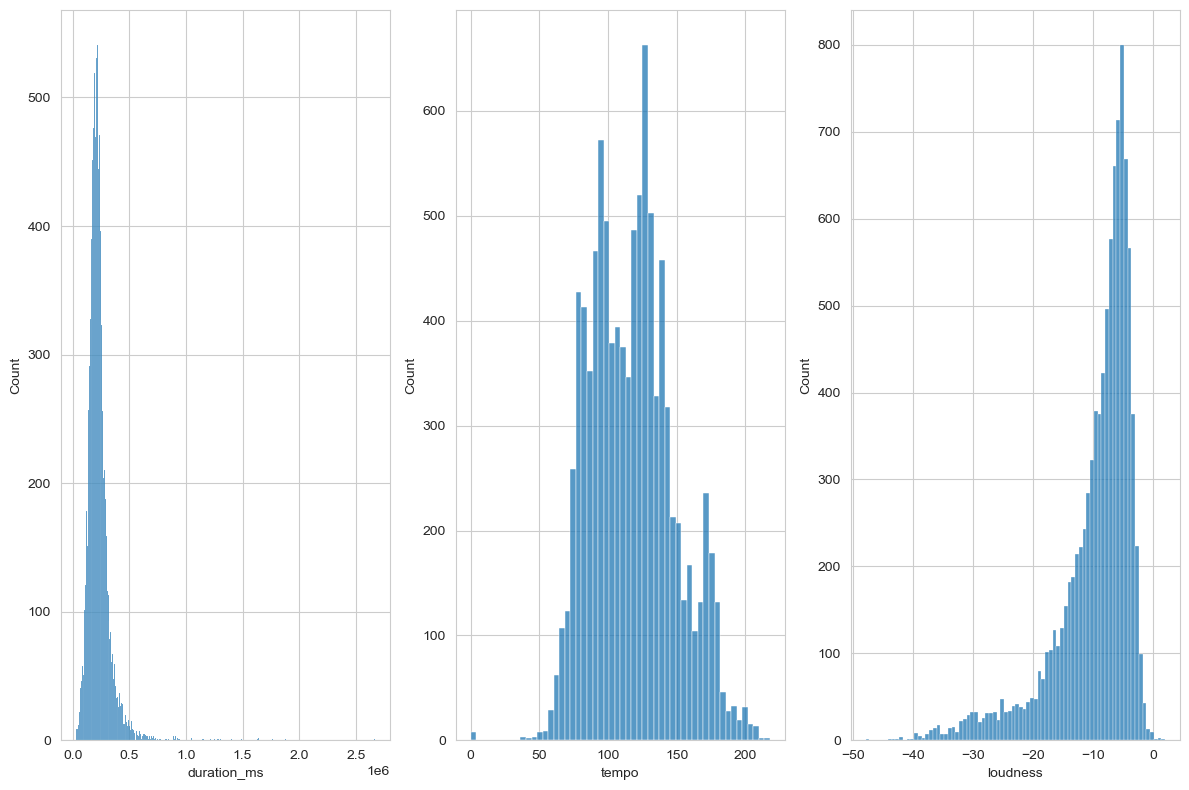

In [13]:
# Examine the distributions of unscaled continuous features
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
sns.histplot(track_data['duration_ms'])

plt.subplot(1, 3, 2)
sns.histplot(track_data['tempo'])

plt.subplot(1, 3, 3)
sns.histplot(track_data['loudness'])

plt.tight_layout()
plt.show()

Of these three, the distribution of tempo is probably the most straightforward, as it is centrally distributed within a relatively narrow range. Although the underlying data is most likely multi-modal, standard scaling is appropriate for a first pass.

Several attempts at transforming loudness were attempted (log-scaling, square-root scaling, Yeo-Johnson, omitted here for clarity), but did not reduce the skew. Because the distribution is also confined to a relatively narrow range, I will try standard-scaling here as well. Many of the model output features are also skewed within their 0-1 range, so these can all be revisited in later iterations, if necessary.

The duration distribution has a very long tail and is a good candidate for a log transformation.

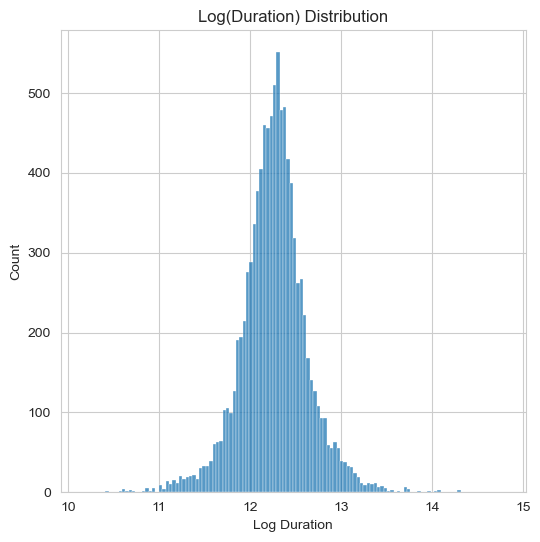

In [14]:
# Plot the log of duration
plt.figure(figsize=(6, 6))

plt.title('Log(Duration) Distribution')
plt.xlabel('Log Duration')
sns.histplot(np.log(track_data['duration_ms']))

plt.show()

The log of duration appears to be normally distributed, so standard scaling after this transformation is a good choice.

In [12]:
# Log transform the duration
track_data['duration_ms'] = np.log(track_data['duration_ms'])

#### Stratified Split of Data and Numeric Scaling

To avoid data leakage, it is necessary to split the data prior to scaling the numeric features. In multi-label classification, this can be challenging due to the rarity of labels or label features. The filtering from earlier will help alleviate this issue, but it is also beneficial to stratify the labels across splits such that there is an appropriate distribution between the training and test datasets.

Because the conversion from pandas DataFrame to split NumPy arrays will be a task I repeat often, I have created a custom Dataset class to handle that task and also log the characteristics of the pre- and post-split data. The scikit-multilearn library includes functionality to iteratively split datasets maintaining a representative label distribution and this class includes a modification to that function which also splits the identifiers by the same indices.

In [13]:
track_dataset = Dataset(track_data, training_features, filtered_genres, 'track_id')

In [14]:
# Separate features, labels, and ids, and perform stratified split
X_train, y_train, ids_train, X_test, y_test, ids_test = track_dataset.split_data(test_size=0.2, iterative=True)

The final transformation before first-pass modeling will be applying the numeric scaling to the features discussed above.

In [15]:
# Convert data back into pandas structures for now to allow for easier manipulation
X_train = pd.DataFrame(X_train, columns=training_features)
X_test = pd.DataFrame(X_test, columns=training_features)

scaler = StandardScaler()
X_train[['duration_ms', 'tempo', 'loudness']] = scaler.fit_transform(X_train[['duration_ms', 'tempo', 'loudness']])
X_test[['duration_ms', 'tempo', 'loudness']] = scaler.transform(X_test[['duration_ms', 'tempo', 'loudness']])

In [15]:
X_train.describe()

,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
count,7.743000e+03,7743.000000,7743.000000,7743.000000,7743.000000,7743.000000,7.743000e+03,7743.000000,7.743000e+03,7743.000000,...,7743.000000,7743.000000,7743.000000,7743.000000,7743.000000,7743.000000,7743.000000,7743.00000,7743.000000,7743.000000
mean,4.226734e-14,0.354857,0.576450,0.566907,0.202658,0.175796,6.065721e-16,0.087286,-3.461407e-15,0.472791,...,0.093633,0.066383,0.076327,0.386414,0.613586,0.000646,0.008524,0.09712,0.879375,0.014336
std,1.000065e+00,0.352609,0.193988,0.274494,0.347209,0.141714,1.000065e+00,0.088613,1.000065e+00,0.263324,...,0.291336,0.248966,0.265538,0.486959,0.486959,0.025405,0.091936,0.29614,0.325712,0.118877
min,-5.333269e+00,0.000002,0.000000,0.001100,0.000000,0.015700,-5.796694e+00,0.000000,-3.886681e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-5.424424e-01,0.034000,0.454000,0.371000,0.000000,0.093000,-3.388965e-01,0.036800,-7.910903e-01,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
50%,2.087293e-02,0.203000,0.595000,0.606000,0.000154,0.119000,3.153309e-01,0.048700,3.584044e-04,0.470000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,5.272704e-01,0.688000,0.726000,0.793000,0.252000,0.210000,6.646910e-01,0.090850,6.528138e-01,0.687000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
max,6.793605e+00,0.996000,0.979000,0.999000,0.994000,1.000000,1.757718e+00,0.662000,3.290823e+00,0.988000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [16]:
X_test.describe()

,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
count,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,...,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000
mean,-0.001177,0.362321,0.574556,0.563692,0.214109,0.172740,-0.036031,0.087814,-0.014542,0.473063,...,0.097525,0.073265,0.078603,0.384765,0.615235,0.001456,0.010189,0.102377,0.868996,0.016982
std,1.029155,0.355200,0.196671,0.281171,0.356906,0.137155,1.047841,0.086559,0.993131,0.265755,...,0.296744,0.260635,0.269183,0.486658,0.486658,0.038134,0.100451,0.303218,0.337487,0.129235
min,-5.673957,0.000004,0.000000,0.001460,0.000000,0.018700,-4.751261,0.000000,-3.886681,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.528916,0.039200,0.445000,0.346000,0.000000,0.093100,-0.375066,0.037200,-0.769588,0.248000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.002274,0.219000,0.593000,0.610000,0.000148,0.119000,0.308823,0.050600,-0.016666,0.481000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.522695,0.706000,0.724000,0.795000,0.334000,0.204000,0.666129,0.096200,0.608821,0.684000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.483782,0.996000,0.969000,0.999000,0.987000,0.983000,1.604415,0.713000,3.161247,0.985000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Overall, the distributions of the scaled variables look close to standard normal in both splits. The distributions of the other features also appear to be relatively stable, so the data should be ready for initial modeling.

In [16]:
# Convert back to numpy arrays for modeling
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
# Get dataset characteristics for future reference
baseline_dataset_chars = track_dataset.get_dataset_characteristics()

### Baseline Modeling

Three common first-line approaches for multi-label classification are Binary Relevance, Classifier Chains, and Label Powerset models. All three of these are metamodels which rely on some underlying base model to predict part of the problem. Using these with a logistic regression base provides a good set of baseline models because they will need to be run numerous times throughout feature engineering and the setup is fairly computationally inexpensive. Furthermore, running three different models may highlight different strengths and weaknesses of features. The modeling setup will remain fixed throughout feature exploration for better comparison between the various features.

To better organize and centralize related model runs and logs, I have implemented an Experiment class that is able to fit and predict multiple models on the same dataset. Such a structure is useful for organizing several model runs and can be used later in model exploration because it allows multiple models to run against a single data set. I have also implemented a custom Metrics class that calculates and stores all metrics for each model run for better organization and retrieval.

In [17]:
# Create models from predefined baseline configuration, see /models/config.py
baseline_names = ['br_baseline', 'cc_baseline', 'lp_baseline']
baseline_models, baseline_configs = experiment_setup(baseline_experiment_configs, baseline_names)

In [18]:
# Create experiment instance
baseline_experiment = Experiment(X_train, y_train, X_test, y_test, baseline_dataset_chars)

In [24]:
# baseline_tags = {name: {'Comments': 'Baseline', 'Label Threshold': '10'} for name in baseline_names}
# baseline_experiment.run_experiment(baseline_models, baseline_configs, mlflow_path, tags= baseline_tags, save_models=False)

2024/03/14 15:10:42 INFO mlflow.tracking.fluent: Experiment with name '/Users/ishanchowdhur@gmail.com/feature_engineering' does not exist. Creating a new experiment.


Running model: br_baseline
br_baseline complete.
Running model: cc_baseline
cc_baseline complete.
Running model: lp_baseline
lp_baseline complete.


In [25]:
br_metrics = baseline_experiment.results['br_baseline']
cc_metrics = baseline_experiment.results['cc_baseline']
lp_metrics = baseline_experiment.results['lp_baseline']

In [26]:
br_metrics.print_metrics_report()

Hamming Loss: 0.0062
Jaccard Score (Weighted Avg): 0.0340
                                   precision    recall  f1-score   support
                        micro avg      0.564     0.040     0.075      7685
                        macro avg      0.038     0.007     0.011      7685
                     weighted avg      0.166     0.040     0.056      7685
                      samples avg      0.099     0.047     0.057      7685


In [27]:
cc_metrics.print_metrics_report()

Hamming Loss: 0.0066
Jaccard Score (Weighted Avg): 0.0581
                                   precision    recall  f1-score   support
                        micro avg      0.379     0.076     0.126      7685
                        macro avg      0.055     0.021     0.026      7685
                     weighted avg      0.182     0.076     0.096      7685
                      samples avg      0.086     0.077     0.077      7685


In [28]:
lp_metrics.print_metrics_report()

Hamming Loss: 0.0089
Jaccard Score (Weighted Avg): 0.0431
                                   precision    recall  f1-score   support
                        micro avg      0.159     0.095     0.119      7685
                        macro avg      0.041     0.044     0.033      7685
                     weighted avg      0.114     0.095     0.076      7685
                      samples avg      0.169     0.140     0.144      7685


A few takeaways are clear from initial modeling. Hamming loss is very low, meaning the overall fraction of incorrect labels is low. However, this is not very useful at the moment because the label space is large and very sparse. The low Jaccard similarities shows that there is very little overlap between predicted and actual values. Regardless of model or averaging method, the model has extremely low recall, which means that very few of the labels are being picked up. This is also most likely due to the sparsity. However, when the feels confident about a label, it has some skill in predicting it, as the precision values are not as bad.

All three models are showing different types of signal, which is helpful for feature engineering. The Binary Relevance model has very high micro-averaged precision (relatively, it's still poor). The Classifier Chain model has the best weighted-average F1 score which indicates its relative usefulness for predicting each class, especially the rarer ones. The Label Powerset approach is best on a per-track basis, as shown by the sample-averaged results, which is expected as it essentially treats label combinations as unique labels.

Unsurprisingly, all three models lack skill at this point. However, the performance is good enough to establish the presence of some signal between the initial features and labels. This is encouraging, because observing incremental improvements in metrics will indicate whether various feature transformations are having a beneficial effect.

### Reduction of Label Space - Filtering

The most obvious improvement from both a technical and practical perspective is to reduce the label space. This will address many of the issues above and will hopefully improve recall by reducing the sparsity of the labels. The goal of this project is not to predict genres as granular as the ones in Spotify artist profiles. Highly specific genres such as `swedish melodic rock` can be characterized under general ones such as `rock`, and that is still valuable.

However, such an approach will require re-labeling songs that only have such genres, or creating genre clusters. Prior to attempting this, a simpler approach could to just apply a more strict filter, discarding labels with poor representation. This will be a quick way to observe the effect of reducing label sparsity and seeing if the existing features have any predictive value.

In [43]:
GENRE_THRESHOLD = 100
filtered_genres = filter_genres(genre_counts, minimum_tracks=GENRE_THRESHOLD)

Number of genres meeting or exceeding 100 tracks: 98
1889 of 1987 genres do not meet this threshold.


In [21]:
# Employ the same encoding/filtering process as before
filtered_genres_encoded = encode_labels(exploded_genres, filtered_genres)
print(f'After filtering, {100 * filtered_genres_encoded.shape[0] / tracks.shape[0]:.1f}% of the dataset remains, {filtered_genres_encoded.shape[0]} of {tracks.shape[0]} tracks.')

After filtering, 74.3% of the dataset remains, 7736 of 10416 tracks.


Even with this more aggressive filter, a substantial portion of the original data remains.

In [22]:
# Perform the other feature engineering tasks from before: join the encoded labels, one-hot encode categoricals, and log-scale the duration
track_data_label_filter = tracks[['track_id'] + RAW_TRAINING_FEATURES].copy()
track_data_lf = track_data_label_filter.merge(filtered_genres_encoded, left_index=True, right_index=True).reset_index(drop=True)
track_data_lf = pd.get_dummies(track_data_lf, columns=CATEGORICAL_FEATURES, dtype=int)
track_data_lf['duration_ms'] = np.log(track_data_lf['duration_ms'])

In [23]:
# Split and scale the data again, same procedure as before
track_dataset_lf = Dataset(track_data_lf, training_features, filtered_genres, 'track_id')
X_train, y_train, ids_train, X_test, y_test, ids_test = track_dataset_lf.split_data(test_size=0.2, iterative=True)
X_train = pd.DataFrame(X_train, columns=training_features)
X_test = pd.DataFrame(X_test, columns=training_features)

scaler = StandardScaler()
X_train[['duration_ms', 'tempo', 'loudness']] = scaler.fit_transform(X_train[['duration_ms', 'tempo', 'loudness']])
X_test[['duration_ms', 'tempo', 'loudness']] = scaler.transform(X_test[['duration_ms', 'tempo', 'loudness']])

In [24]:
# Prepare data for modeling
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
filtered_labels_dataset_chars = track_dataset_lf.get_dataset_characteristics()

In [ ]:
# Create experiment instance
filtered_label_experiment = Experiment(X_train, y_train, X_test, y_test, filtered_labels_dataset_chars)

In [26]:
# filtered_label_tags = {name: {'Comments': 'Baseline', 'Label Threshold': '100'} for name in baseline_names}
# filtered_label_experiment.run_experiment(baseline_models, baseline_configs, mlflow_path, tags= filtered_label_tags, save_models=False)

Running model: br_baseline
br_baseline complete.
Running model: cc_baseline
cc_baseline complete.
Running model: lp_baseline
lp_baseline complete.


In [31]:
# # Inspect results
# filtered_label_experiment.results['br_baseline'].print_metrics_report()

Hamming Loss: 0.0299
Jaccard Score (Weighted Avg): 0.0793
                        precision    recall  f1-score   support
             micro avg      0.599     0.094     0.163      4659
             macro avg      0.216     0.050     0.069      4659
          weighted avg      0.306     0.094     0.123      4659
           samples avg      0.179     0.119     0.129      4659


In [28]:
# filtered_label_experiment.results['cc_baseline'].print_metrics_report()

Hamming Loss: 0.0323
Jaccard Score (Weighted Avg): 0.1240
                        precision    recall  f1-score   support
             micro avg      0.440     0.164     0.239      4659
             macro avg      0.274     0.118     0.143      4659
          weighted avg      0.337     0.164     0.194      4659
           samples avg      0.183     0.190     0.177      4659


In [29]:
# filtered_label_experiment.results['lp_baseline'].print_metrics_report()

Hamming Loss: 0.0398
Jaccard Score (Weighted Avg): 0.1071
                        precision    recall  f1-score   support
             micro avg      0.284     0.190     0.228      4659
             macro avg      0.274     0.178     0.162      4659
          weighted avg      0.314     0.190     0.178      4659
           samples avg      0.298     0.270     0.270      4659




Because the dataset collection was not comprehensive, there are problems with using such a crude filtering approach to reduce the number of labels this way
- The filtered genres should represent nearly all tracks, i.e., there should not be tracks which do not strongly associate with a label. This is likely not the case.
- Related to the previous issue, there should not be broad genres or sub-genres that are excluded 
- Genres can be divided into subgenres with different degrees of granularity. For example, there could be 3 types of hip-hop and 400 types of rock music. This method could eliminate the rock sub-genres due to lower frequency even if rock is a more common genre than hip-hop.

### Reduction of Label Space - Clustering

A better solution is to cluster the existing genres into broader genres that are still distinct and useful for classification. This approach also benefits from retaining more data, since it becomes possible to generate labels for tracks with only niche genres.

Clustering the labels is an effort-intensive process, so for clarity, please refer to the `label_clustering` notebook to see how this process was conducted. 

In [139]:
# Import cluster definitions
CLUSTER_PATH = Path(os.getenv('PROJECT_ROOT'), '.') / 'clustering'
CLUSTER_FILE = CLUSTER_PATH / 'cluster_genres.pkl'

with open(CLUSTER_FILE, 'rb') as file:
    cluster_genres = pickle.load(file)

In [140]:
# For easier lookups in later steps, invert the structure of the cluster dictionary such that key is genre and value is cluster
genre_clusters = {}
for cluster_name, cluster_genre_list in cluster_genres.items():
    for genre_name in cluster_genre_list:
        genre_clusters[genre_name] = cluster_name
        
# Also store the list of cluster names, since these will become the new labels
cluster_names = list(cluster_genres.keys())

Even though the genres are being clustered, some initial filtering was still performed to generate the clusters at the expense of a small portion of the dataset. This is discussed in more detail in the `label_clustering` notebook.

Otherwise, the procedure is mostly the same.

In [141]:
# Get filtered genres again
GENRE_THRESHOLD = 10
filtered_genres = filter_genres(genre_counts, GENRE_THRESHOLD)

Number of genres meeting or exceeding 10 tracks: 591
1396 of 1987 genres do not meet this threshold.


Filtering on the genres will yield the same 94.1% of the original dataset as it did before. In order to re-use the filter and encoding function from earlier, it is necessary to map the exploded genres DataFrame to a corresponding exploded genre cluster DataFrame

In [157]:
exploded_clusters = exploded_genres['artist_genres'].map(genre_clusters).rename('genre_clusters').to_frame()

# Encode as before, this function will also eliminate unmapped genres from the step above
clusters_encoded = encode_labels(exploded_clusters, cluster_names)

In [12]:
# Create a new DataFrame and join in the labels
track_data_clustered = tracks[['track_id'] + RAW_TRAINING_FEATURES].copy()
track_data_c = track_data_clustered.merge(clusters_encoded, left_index=True, right_index=True).reset_index(drop=True)

In [ ]:
# One-hot encode the categoricals features and log-scale duration
track_data_c = pd.get_dummies(track_data_c, columns=CATEGORICAL_FEATURES, dtype=int)
track_data_c['duration_ms'] = np.log(track_data_c['duration_ms'])

In [ ]:
# Split dataset and scale the numeric features
track_dataset_c = Dataset(track_data_c, training_features, cluster_names, 'track_id')
X_train, y_train, ids_train, X_test, y_test, ids_test = track_dataset_c.split_data(test_size=0.2, iterative=True)
X_train = pd.DataFrame(X_train, columns=training_features)
X_test = pd.DataFrame(X_test, columns=training_features)

scaler = StandardScaler()
X_train[['duration_ms', 'tempo', 'loudness']] = scaler.fit_transform(X_train[['duration_ms', 'tempo', 'loudness']])
X_test[['duration_ms', 'tempo', 'loudness']] = scaler.transform(X_test[['duration_ms', 'tempo', 'loudness']])

In [ ]:
# Prepare data for modeling
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
clustered_labels_dataset_chars = track_dataset_c.get_dataset_characteristics()
clustered_label_experiment = Experiment(X_train, y_train, X_test, y_test, clustered_labels_dataset_chars)

In [ ]:
clustered_label_tags = {name: {'Comments': 'Baseline', 'Label Threshold': '10'} for name in baseline_names}
clustered_label_experiment.run_experiment(baseline_models, baseline_configs, mlflow_path, tags=clustered_label_tags, save_models=False)

In [ ]:
# Inspect results
clustered_label_experiment.results['br_baseline'].print_metrics_report()

In [ ]:
clustered_label_experiment.results['cc_baseline'].print_metrics_report()

In [ ]:
clustered_label_experiment.results['lp_baseline'].print_metrics_report()